# Feature Engineering

This notebook create new features and mesures the the perfomance change in the model. The goal is to create features to increase the model performance.

In [45]:
# Libraries
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

### Import the data

In [46]:
# Read the data to a pandas data frame
df = pd.read_csv('apartments_data_enriched_lat_lon_combined.csv', sep=',', encoding='utf-8')
# Get number of rows and columns
df.shape

(2400, 18)

In [47]:
df.columns

Index(['bfs_number', 'rooms', 'area', 'price', 'postalcode', 'address', 'town',
       'description_raw', 'bfs_name', 'pop', 'pop_dens', 'frg_pct', 'emp',
       'tax_income', 'lat', 'lon', 'x', 'y'],
      dtype='object')

## Model Performance

In [48]:
def model_performance(features, df, random_forest_model = RandomForestRegressor(random_state=42)):
    df = df.sample(frac=1, random_state=42)
    X, y = df[features], df['price']
    scores = cross_val_score(random_forest_model, X, y, scoring="neg_root_mean_squared_error", cv=5)
    print('CV results RMSE:', np.round(scores))
    print('Mean RMSE:', np.mean(np.round(scores, 0)))

In [49]:
features = ['rooms', 'area', 'pop', 'pop_dens', 'frg_pct', 'emp', 'tax_income']
model_performance(features, df)

CV results RMSE: [-836. -687. -748. -891. -629.]
Mean RMSE: -758.2


## Data Cleaning
- Remove apartments with empty columns
- Remove apartments which price exceeds 6000.-
- Remove apartments which price is lower than 1000.-

In [50]:
print('Total apartment before data cleaning:', len(df))

# Remove missing values
df = df.dropna()

# Remove duplicates
df = df.drop_duplicates()

# Remove some 'extreme' values
df = df.loc[(df['price'] >= 750) & 
            (df['price'] <= 8000)]

print('Total apartment after data cleaning:', len(df))

Total apartment before data cleaning: 2400
Total apartment after data cleaning: 2344


In [51]:
# Before data cleaning Mean RMSE: -894.8

features = ['rooms', 'area', 'pop', 'pop_dens', 'frg_pct', 'emp', 'tax_income']
model_performance(features, df)

CV results RMSE: [-698. -643. -743. -678. -607.]
Mean RMSE: -673.8


## Feature engineering

### Create additional variables from the apartment's descriptions

In [52]:
# Create the new variable
df['room_per_m2'] = round(df['area'] / df['rooms'], 2)
df['price_per_m2'] = round(df['price'] / df['area'], 2)

In [53]:
# Without new features the performance is: AVG RMSE: -862.86

features = ['rooms', 'area', 'pop', 'pop_dens', 'frg_pct', 'emp', 'tax_income', 'room_per_m2']
model_performance(features, df)

CV results RMSE: [-687. -652. -711. -666. -602.]
Mean RMSE: -663.6


In [54]:
# Without new features the performance is: AVG RMSE: -862.86

features = ['rooms', 'area', 'pop', 'pop_dens', 'frg_pct', 'emp', 'tax_income', 'room_per_m2', 'price_per_m2']
model_performance(features, df)

CV results RMSE: [-109. -120. -188.  -87. -177.]
Mean RMSE: -136.2


<div style="border-left: 4px solid #0073e6; padding: 10px; background-color: #e6f2ff; color: black;">
  <strong>Question:</strong>Why is the performance, nearly perfect, when using the feature 'price_per_m2'?
</div>
<div style="border-left: 4px solid #0073e6; padding: 10px; background-color: #e6f2ff; color: black;">
  <strong>Answer:</strong> <span style="background-color: black; color: black;" onmouseover="this.style.color='white'" onmouseout="this.style.color='black'">The feature 'price_per_m2' represents the price per square meter, which is the target variable we aim to predict. If you know both the area and 'price_per_m2', calculating the total price becomes straightforward.</span>
</div>

#### Create new binary (0/1) variable 'luxurious'

In [55]:
# Create a pattern which can be used to search the variable 'description_raw'
pattern = '(LOFT)|(SEESICHT)|(ATTIKA)|(LUXURIÖS)|(LUXU)|(POOL)|(EXKLUSIV)'

# Create new variable 'luxurious' as binary dummy (0/1) variable
df['luxurious'] = df['description_raw'].str.contains(pat = pattern).astype(int)
print('Total of Luxurious Apartments', df['luxurious'].sum())

Total of Luxurious Apartments 17


#### Create new binary (0/1) variable 'temporary'

In [56]:
# Create a pattern which can be used to search the variable 'description_raw'
pattern = '(TEMPOR)|(BEFRIST)'

# Create new variable 'luxurious' as binary dummy (0/1) variable
df['temporary'] = df['description_raw'].str.contains(pat = pattern).astype(int)
print('Total of Temporary Apartments', df['temporary'].sum())

Total of Temporary Apartments 50


#### Create new binary (0/1) variable 'furnished'

In [57]:
# Create a pattern which can be used to search the variable 'description_raw'
pattern = '(FURNISHED)|(MÖBLIERT)|(FURNISHE)'

# Create new variable 'luxurious' as binary dummy (0/1) variable
df['furnished'] = df['description_raw'].str.contains(pat = pattern).astype(int)
print('Total of Furnished Apartments', df['furnished'].sum())

Total of Furnished Apartments 52


In [58]:
# Without new features the performance is: AVG RMSE: -862.86

features = ['rooms', 'area', 'pop', 'pop_dens', 'frg_pct', 'emp', 'tax_income', 'room_per_m2', 'luxurious', 'temporary', 'furnished']
model_performance(features, df)

CV results RMSE: [-683. -644. -718. -663. -597.]
Mean RMSE: -661.0


#### Create new categorical variable based on apartment area

In [59]:
labels = ['0 - 49', '50 - 99', '100 - 500']
df["area_cat"] = pd.cut(df.area, bins=[0, 50, 100, 500], labels=labels)
df[['area', 'area_cat']].head(10)

,area,area_cat
0,148,100 - 500
1,122,100 - 500
2,78,50 - 99
3,69,50 - 99
4,74,50 - 99
5,98,50 - 99
6,60,50 - 99
7,64,50 - 99
8,92,50 - 99
9,85,50 - 99


In [60]:
from sklearn.preprocessing import OrdinalEncoder

area_cat = df['area_cat'].values.reshape(-1,1)
ordinal_encoding = OrdinalEncoder()
area_cat_encoded = ordinal_encoding.fit_transform(area_cat) 

df['area_cat_ecoded'] = area_cat_encoded


In [61]:
# Without new features the performance is: AVG RMSE: -862.86

features = ['rooms', 'area', 'pop', 'pop_dens', 'frg_pct', 'emp', 'tax_income', 'room_per_m2', 'luxurious', 'temporary', 'furnished', 'area_cat_ecoded']
model_performance(features, df)

CV results RMSE: [-682. -644. -714. -665. -597.]
Mean RMSE: -660.4


### Luxurious One Hot Encoding
One-Hot Encoding is a technique used in machine learning to convert categorical variables into a binary (0/1) format. Each unique category is represented as a separate column, and a 1 is assigned if that category is present, otherwise, it's 0.

Example:

| description_raw                                         | (ATTIKA) | (EXKLUSIV) | (LOFT) | (LUXURIÖS) | (POOL) | (SEESICHT) | (NONE) |
|---------------------------------------------------------|----------|------------|--------|------------|--------|------------|--------|
| Dieses Apartment ist sehr LUXURIÖS mit POOL.           | 0        | 0          | 0      | 1          | 1      | 0          | 0      |
| Ein tolles LOFT mit SEESICHT und EXKLUSIVEM Design.    | 0        | 1          | 1      | 0          | 0      | 1          | 0      |
| Normale Wohnung ohne Extras.                           | 0        | 0          | 0      | 0          | 0      | 0          | 1      |
| Schöne Aussicht, aber keine besonderen Merkmale.       | 0        | 0          | 0      | 0          | 0      | 0          | 1      |


In [62]:
# If you want to test one hot encoding with multiple categories
#df.loc[0, "description_raw"] = 'Ein tolles LOFT mit SEESICHT und EXKLUSIVEM Design.'
#df.iloc[0].description_raw

In [63]:
# Define terms for encoding
terms = {'(ATTIKA)', '(EXKLUSIV)', '(LOFT)', '(LUXURIÖS)', '(POOL)', '(SEESICHT)'}

# Create one-hot encoded columns
for term in terms:
    df[term] = df['description_raw'].str.contains(term.strip("()"), case=False, na=False).astype(int)


In [64]:
features = ['rooms', 'area', 'pop', 'pop_dens', 'frg_pct', 'emp', 'tax_income', 'room_per_m2', 'luxurious', 'temporary', 'furnished', 'area_cat_ecoded',
       '(LUXURIÖS)', '(POOL)', '(SEESICHT)',
       '(EXKLUSIV)', '(ATTIKA)', '(LOFT)']
model_performance(features, df)

CV results RMSE: [-685. -642. -702. -658. -608.]
Mean RMSE: -659.0


### Split Zurich into Kreis

<div style="border-left: 4px solid #0073e6; padding: 10px; background-color: #e6f2ff; color: black;">
  <strong>Note:</strong>To obtain the latitude and longitude, please refer to the slides attachment. We haven't included them here because they are extracted from an API, and if every student attempts to retrieve them, the API may not respond well. 😉
</div>

In [65]:
bfs_number_counts = df.groupby(['bfs_number', 'town']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
print(bfs_number_counts)

     bfs_number         town  counts
261         261       Zürich     560
263         261       Zürich     188
235         230   Winterthur     147
237         230   Winterthur     102
184         191    Dübendorf      38
..          ...          ...     ...
183         180  Weisslingen       1
90           90    Oberhasli       1
181         178     Russikon       1
27           34      Dachsen       1
79           84     Dällikon       1

[276 rows x 3 columns]


In [66]:
from shapely.geometry import Point
import geopandas as gpd

# Convert lat/lon to Shapely Points
df['geometry'] = df.apply(lambda row: Point(row['lon'], row['lat']), axis=1)

# Load GeoDataFrame with polygons of the city of Zurich
gdf = gpd.read_file('stzh.adm_stadtkreise_a.json')

# Initialize one-hot encoding columns with 0s
for name in gdf['bezeichnung']:
    df[name] = 0  

# Iterate through each polygon and check if the points are inside
for _, row in gdf.iterrows():
    polygon_name = row['bezeichnung']
    polygon_geom = row['geometry']
    
    # Check if each point is inside the polygon and update the corresponding column
    df[polygon_name] = df['geometry'].apply(lambda point: 1 if polygon_geom.contains(point) else 0)

# Drop the geometry column (optional)
df.drop(columns=['geometry'], inplace=True)
df.head()

,bfs_number,rooms,area,price,postalcode,address,town,description_raw,bfs_name,pop,...,Kreis 12,Kreis 10,Kreis 4,Kreis 1,Kreis 9,Kreis 5,Kreis 7,Kreis 3,Kreis 2,Kreis 8
0,261,4.5,148,4180,8050,"Schaffhauserstrasse 363, 8050 Zürich",Zürich,««Renovierte 4.5-Zimmerwohnung an zentraler La...,Zürich,420217,...,0,0,0,0,0,0,0,0,0,0
1,261,2.0,122,3190,8050,"Max Bill Platz 5, 8050 Zürich",Zürich,«Modernes Wohnen im Zentrum von Oerlikon»,Zürich,420217,...,0,0,0,0,0,0,0,0,0,0
2,261,3.5,78,2780,8050,"Regensbergstrasse 30, 8050 Zürich",Zürich,«Wohnen am Puls von Zürich»,Zürich,420217,...,0,0,0,0,0,0,0,0,0,0
3,261,3.5,69,3750,8050,"Dörflistrasse 112, 8050 Zürich",Zürich,"«Trendy Oerlikon 3.5 Room w/ Balcony, 1min to ...",Zürich,420217,...,0,0,0,0,0,0,0,0,0,0
4,261,3.5,74,2390,8050,"Schaffhauserstrasse 445, 8050 Zürich",Zürich,«Helle und zentrale Wohnung in Zürich-Oerlikon»,Zürich,420217,...,0,0,0,0,0,0,0,0,0,0


In [67]:
df[df.bfs_number == 261][['town', 'address', "Kreis 1", "Kreis 2", "Kreis 3", "Kreis 4", 
        "Kreis 5", "Kreis 6", "Kreis 7", "Kreis 8", 
        "Kreis 9", "Kreis 10", "Kreis 11", "Kreis 12"]].head(10)

,town,address,Kreis 1,Kreis 2,Kreis 3,Kreis 4,Kreis 5,Kreis 6,Kreis 7,Kreis 8,Kreis 9,Kreis 10,Kreis 11,Kreis 12
0,Zürich,"Schaffhauserstrasse 363, 8050 Zürich",0,0,0,0,0,0,0,0,0,0,1,0
1,Zürich,"Max Bill Platz 5, 8050 Zürich",0,0,0,0,0,0,0,0,0,0,1,0
2,Zürich,"Regensbergstrasse 30, 8050 Zürich",0,0,0,0,0,0,0,0,0,0,1,0
3,Zürich,"Dörflistrasse 112, 8050 Zürich",0,0,0,0,0,0,0,0,0,0,1,0
4,Zürich,"Schaffhauserstrasse 445, 8050 Zürich",0,0,0,0,0,0,0,0,0,0,1,0
5,Zürich,"Eggbühlstrasse 9, 8050 Zürich",0,0,0,0,0,0,0,0,0,0,1,0
6,Zürich,"Leutschenbachstrasse 46, 8050 Zürich",0,0,0,0,0,0,0,0,0,0,1,0
7,Zürich,"Siewerdtstrasse 19, 8050 Zürich",0,0,0,0,0,0,0,0,0,0,1,0
8,Zürich,"Siewerdtstrasse 19, 8050 Zürich",0,0,0,0,0,0,0,0,0,0,1,0
9,Zürich,"Siewerdtstrasse 19, 8050 Zürich",0,0,0,0,0,0,0,0,0,0,1,0


In [68]:
features = ['rooms', 'area', 'pop', 'pop_dens', 'frg_pct', 'emp', 'tax_income', 'room_per_m2', 'luxurious', 'temporary', 'furnished', 'area_cat_ecoded',
       '(LUXURIÖS)', '(POOL)', '(SEESICHT)',
       '(EXKLUSIV)', '(ATTIKA)', '(LOFT)', 'Kreis 6', 'Kreis 11', 'Kreis 12', 'Kreis 10',
       'Kreis 4', 'Kreis 1', 'Kreis 9', 'Kreis 5', 'Kreis 7', 'Kreis 3',
       'Kreis 2', 'Kreis 8']
model_performance(features, df)

CV results RMSE: [-633. -610. -632. -631. -579.]
Mean RMSE: -617.0


### Fix pop_dens and pop of city of zurich

In [69]:
# Creating the DataFrame with pop and pop_dens for each Kreis
data = {
    "ID": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    "Kreis": [
        "Kreis 1", "Kreis 2", "Kreis 3", "Kreis 4", 
        "Kreis 5", "Kreis 6", "Kreis 7", "Kreis 8", 
        "Kreis 9", "Kreis 10", "Kreis 11", "Kreis 12"
    ],
    "pop": [5890, 37639, 50950, 29944, 15874, 35688, 39647, 17860, 59841, 41411, 78801, 33537],
    "pop_dens": [3232, 3254, 5792, 10008, 7942, 6932, 2574, 3704, 4729, 4512, 5736, 5470]
}

zuerich_pop_dens = pd.DataFrame(data)
zuerich_pop_dens

,ID,Kreis,pop,pop_dens
0,1,Kreis 1,5890,3232
1,2,Kreis 2,37639,3254
2,3,Kreis 3,50950,5792
3,4,Kreis 4,29944,10008
4,5,Kreis 5,15874,7942
5,6,Kreis 6,35688,6932
6,7,Kreis 7,39647,2574
7,8,Kreis 8,17860,3704
8,9,Kreis 9,59841,4729
9,10,Kreis 10,41411,4512


In [70]:
#Applying pop and pop_dens to df of Zurich
kreis_columns = ['Kreis 6', 'Kreis 11', 'Kreis 12', 'Kreis 10', 'Kreis 4', 'Kreis 1', 'Kreis 9', 'Kreis 5', 'Kreis 7', 'Kreis 3', 'Kreis 2', 'Kreis 8']

for kreis_nr in kreis_columns:
    df.loc[df[kreis_nr] == 1, 'pop'] = zuerich_pop_dens[zuerich_pop_dens['Kreis'] == kreis_nr]['pop'].values[0]
    df.loc[df[kreis_nr] == 1, 'pop_dens'] = zuerich_pop_dens[zuerich_pop_dens['Kreis'] == kreis_nr]['pop_dens'].values[0]

In [71]:
df[df.bfs_number==261].pop_dens

0       5736.0
1       5736.0
2       5736.0
3       5736.0
4       5736.0
         ...  
1861    5792.0
1862    5792.0
1863    5792.0
1864    5792.0
1865    4729.0
Name: pop_dens, Length: 756, dtype: float64

In [72]:
features = ['rooms', 'area', 'pop', 'pop_dens', 'frg_pct', 'emp', 'tax_income', 'room_per_m2', 'luxurious', 'temporary', 'furnished', 'area_cat_ecoded',
       '(LUXURIÖS)', '(POOL)', '(SEESICHT)',
       '(EXKLUSIV)', '(ATTIKA)', '(LOFT)', 'Kreis 6', 'Kreis 11', 'Kreis 12', 'Kreis 10',
       'Kreis 4', 'Kreis 1', 'Kreis 9', 'Kreis 5', 'Kreis 7', 'Kreis 3',
       'Kreis 2', 'Kreis 8']
model_performance(features, df)

CV results RMSE: [-633. -609. -612. -624. -593.]
Mean RMSE: -614.2


In [73]:
df['zurich_city'] = 0
df.loc[df[kreis_columns].any(axis=1), 'zurich_city'] = 1

In [74]:
features = ['rooms', 'area', 'pop', 'pop_dens', 'frg_pct', 'emp', 'tax_income', 'room_per_m2', 'luxurious', 'temporary', 'furnished', 'area_cat_ecoded',
       '(LUXURIÖS)', '(POOL)', '(SEESICHT)',
       '(EXKLUSIV)', '(ATTIKA)', '(LOFT)', 'Kreis 6', 'Kreis 11', 'Kreis 12', 'Kreis 10',
       'Kreis 4', 'Kreis 1', 'Kreis 9', 'Kreis 5', 'Kreis 7', 'Kreis 3',
       'Kreis 2', 'Kreis 8', 'zurich_city']
model_performance(features, df)

CV results RMSE: [-634. -608. -612. -624. -594.]
Mean RMSE: -614.4


<Axes: ylabel='features'>

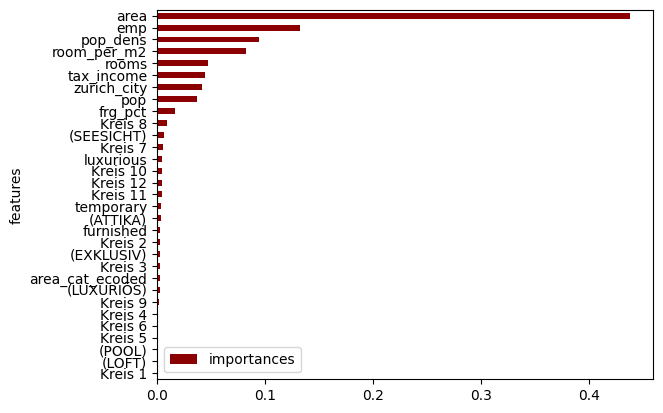

In [75]:
# train random_forest_model = RandomForestRegressor()
random_forest_model = RandomForestRegressor(random_state=42)

# Fit the model
random_forest_model.fit(df[features], df.price)

cols = random_forest_model.feature_names_in_

# Derive feature importance from random forest
importances = random_forest_model.feature_importances_
std         = np.std([tree.feature_importances_ for tree in random_forest_model.estimators_], axis=0)
indices     = np.argsort(importances)[::-1]

# Barplot with feature importance
df_fi = pd.DataFrame({'features':cols,'importances': importances})
df_fi.sort_values('importances', inplace=True)
df_fi.plot(kind='barh', 
           y='importances',
           x='features', 
           color='darkred')

In [76]:
features = ['rooms', 'area', 'pop', 'pop_dens', 'frg_pct', 'emp', 'tax_income', 'room_per_m2', 'luxurious', 'temporary', 'furnished', 'area_cat_ecoded', 'zurich_city']
model_performance(features, df)

CV results RMSE: [-639. -603. -613. -635. -598.]
Mean RMSE: -617.6


<Axes: ylabel='features'>

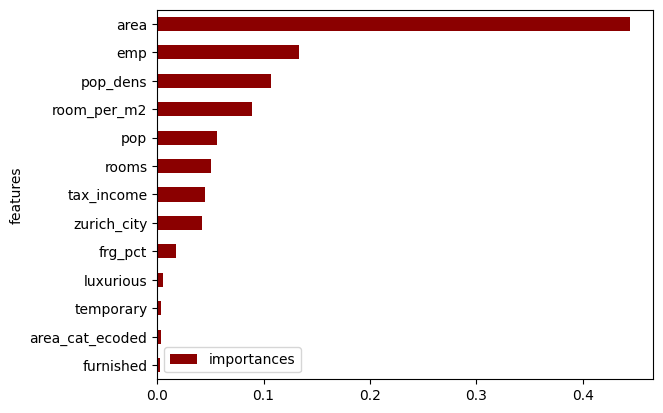

In [77]:
# train random_forest_model = RandomForestRegressor()
random_forest_model = RandomForestRegressor(random_state=42)

# Fit the model
random_forest_model.fit(df[features], df.price)

cols = random_forest_model.feature_names_in_

# Derive feature importance from random forest
importances = random_forest_model.feature_importances_
std         = np.std([tree.feature_importances_ for tree in random_forest_model.estimators_], axis=0)
indices     = np.argsort(importances)[::-1]

# Barplot with feature importance
df_fi = pd.DataFrame({'features':cols,'importances': importances})
df_fi.sort_values('importances', inplace=True)
df_fi.plot(kind='barh', 
           y='importances',
           x='features', 
           color='darkred')

### Error analysis

In [78]:
# get all predictions for the training set.

# train random_forest_model = RandomForestRegressor()
random_forest_model = RandomForestRegressor(random_state=42)

# Fit the model
random_forest_model.fit(df[features], df.price)

price_prediction = random_forest_model.predict(df[features])
df_with_residual = pd.DataFrame(df[features], columns=df[features].columns, copy=True)
df_with_residual['recidual (error)'] = np.abs(price_prediction - df.price)
df_with_residual['price'] = df.price
df_with_residual['predicted_price'] = price_prediction
print(df_with_residual.head())
# Add text, postalcode and town name
# we use join instead of merge, because we 'join' on the index column and do not perform a merge using a specific column
df_with_residual = df_with_residual.join(df[['description_raw', 'bfs_name', 'postalcode', 'town']])

   rooms  area    pop  pop_dens    frg_pct       emp  tax_income  room_per_m2  \
0    4.5   148  78801    5736.0  32.458468  491193.0       85446        32.89   
1    2.0   122  78801    5736.0  32.458468  491193.0       85446        61.00   
2    3.5    78  78801    5736.0  32.458468  491193.0       85446        22.29   
3    3.5    69  78801    5736.0  32.458468  491193.0       85446        19.71   
4    3.5    74  78801    5736.0  32.458468  491193.0       85446        21.14   

   luxurious  temporary  furnished  area_cat_ecoded  zurich_city  \
0          0          0          0              1.0            1   
1          0          0          0              1.0            1   
2          0          0          0              2.0            1   
3          0          0          0              2.0            1   
4          0          0          0              2.0            1   

   recidual (error)  price  predicted_price  
0         43.580000   4180      4136.420000  
1        345

In [79]:
# check which location has the largest errors.
df_with_residual[(df_with_residual['recidual (error)'] > 500)].groupby(['pop', 'bfs_name']).size().sort_values(ascending=False)

pop     bfs_name         
41411   Zürich               14
50950   Zürich               13
39647   Zürich               10
78801   Zürich                8
37639   Zürich                8
420217  Zürich                7
29944   Zürich                6
113173  Winterthur            5
17860   Zürich                4
13067   Zollikon              4
59841   Zürich                3
29303   Dübendorf             3
18791   Schlieren             3
18139   Thalwil               3
18540   Regensdorf            3
15874   Zürich                3
4840    Oetwil am See         2
18944   Adliswil              2
21014   Opfikon               2
27746   Dietikon              2
16841   Wallisellen           2
7727    Langnau am Albis      2
35688   Zürich                2
17333   Illnau-Effretikon     1
8923    Kilchberg (ZH)        1
5602    Nürensdorf            1
6485    Fehraltorf            1
7228    Oberglatt             1
8689    Fällanden             1
11359   Männedorf             1
9981    Urdorf

In [80]:

df_with_residual[(df_with_residual['recidual (error)'] > 800)].to_csv('data_with_large_residuals.csv', 
          sep=",", 
          encoding='utf-8',
          index=False)

## Find the best parameters
- GridSearch
- RandomSearchCV

In [81]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': [100, 500, 1000]}
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3,
scoring='neg_root_mean_squared_error', verbose = 2)
grid_search.fit(df[features], df.price)

# get best estimator:
grid_search.best_estimator_


Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END ...................................n_estimators=100; total time=   0.4s
[CV] END ...................................n_estimators=100; total time=   0.3s
[CV] END ...................................n_estimators=100; total time=   0.4s
[CV] END ...................................n_estimators=500; total time=   2.2s


KeyboardInterrupt: 

In [38]:
features = ['rooms', 'area', 'pop', 'pop_dens', 'frg_pct', 'emp', 'tax_income', 'room_per_m2', 'luxurious', 'temporary', 'furnished', 'area_cat_ecoded', 'zurich_city']
model_performance(features, df)

print('After GridSearch')
model_performance(features, df, RandomForestRegressor(n_estimators=1000, random_state=42))



CV results RMSE: [-639. -603. -613. -635. -598.]
Mean RMSE: -617.6
After GridSearch
CV results RMSE: [-638. -600. -609. -621. -595.]
Mean RMSE: -612.6


In [39]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {'max_depth': [90, 100, 110],
'max_features': [6, 9],
'min_samples_leaf': [4, 5],
'min_samples_split': [10, 12],
'n_estimators': [100, 500, 1000]
}

clf = RandomizedSearchCV(RandomForestRegressor(random_state=42), param_grid, random_state=0, n_iter=10, verbose=2)
search = clf.fit(df[features], df.price)

print(search.best_estimator_)
model_performance(features, df, search.best_estimator_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=100, max_features=6, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=   2.0s
[CV] END max_depth=100, max_features=6, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=   1.8s
[CV] END max_depth=100, max_features=6, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=   1.8s
[CV] END max_depth=100, max_features=6, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=   1.9s
[CV] END max_depth=100, max_features=6, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=   1.8s
[CV] END max_depth=100, max_features=6, min_samples_leaf=4, min_samples_split=12, n_estimators=100; total time=   0.2s
[CV] END max_depth=100, max_features=6, min_samples_leaf=4, min_samples_split=12, n_estimators=100; total time=   0.2s
[CV] END max_depth=100, max_features=6, min_samples_leaf=4, min_samples_split=12, n_estimators=100; t

In [40]:
df.to_csv('apartments_data_enriched_with_new_features.csv')

In [44]:
from shapely.geometry import Point, Polygon
import geopandas as gpd
import pandas as pd
from geopy.distance import geodesic

# Definition der Anflug-/Abflugschneisen als Polygone
anflugschneisen = [
    Polygon([
        (8.533775, 47.482620),
        (8.423897, 47.492865),
        (8.516374, 47.551105),
        (8.535627, 47.483463)
    ]),
    Polygon([
        (8.572260, 47.455645),
        (8.646176, 47.415248),
        (8.666538, 47.473545),
        (8.570504, 47.458323)
    ])
]

# Koordinaten des Flughafens Zürich
flughafen_zuerich = (47.4506, 8.5610)

def is_within_flight_path(lat, lon, flight_paths):
    """ Überprüft, ob eine Wohnung innerhalb einer Anflug-/Abflugschneise liegt."""
    point = Point(lon, lat)
    return any(polygon.contains(point) for polygon in flight_paths)

def distance_to_airport(lat, lon, airport_coords):
    """ Berechnet die Distanz einer Wohnung zum Flughafen Zürich."""
    return geodesic((lat, lon), airport_coords).kilometers

# Features berechnen
df["within_flight_path"] = df.apply(lambda row: is_within_flight_path(row["lat"], row["lon"], anflugschneisen), axis=1)
df["distance_to_airport"] = df.apply(lambda row: distance_to_airport(row["lat"], row["lon"], flughafen_zuerich), axis=1)

# Features zur Modelltraining-Liste hinzufügen
features.append("within_flight_path")
features.append("distance_to_airport")

# Modell erneut trainieren
print('After GridSearch with Flight Path and Distance to Airport Features')
model_performance(features, df, RandomForestRegressor(n_estimators=1000, random_state=42))


After GridSearch with Flight Path and Distance to Airport Features
CV results RMSE: [-616. -603. -574. -602. -587.]
Mean RMSE: -596.4
